# Homework 2, *part 2* (60 points)

In this assignment you will build a heavy convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the validation set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
import tiny_imagenet
# tiny_imagenet.download(".")

Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

In [14]:
# Your code here
import time, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, transforms, models
import os

In [47]:
# Some code from "Transfer Learning Tutorial" (Pytorch Tutorials) was used as an example
 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(30),
#         transforms.RandomResizedCrop(64, scale=(.8, 1.)),
#         transforms.ColorJitter(.1, .1, .1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = './tiny-imagenet-200/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=64)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [16]:
# Use GPU
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [17]:
# Class names and indecies
class_indexes = image_datasets['train'].classes

f = open(os.path.join(data_dir, 'words.txt')) 
words = np.loadtxt(f, delimiter='\t', dtype=object)
words = dict(words)
class_names = list(map(lambda x: words[x], class_indexes))

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

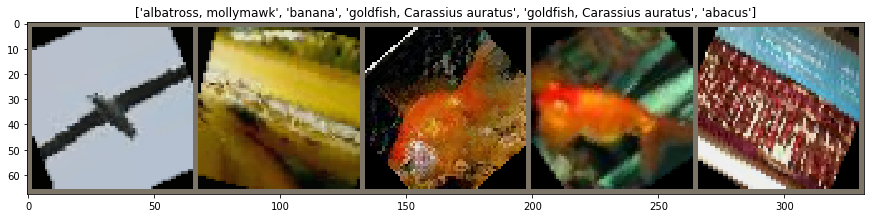

In [19]:
n_show = 5

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:n_show])

imshow(out, title=[class_names[x] for x in classes[:n_show]])

In [20]:
# Training loop
loss_history = {'train': [], 'val': []}
best_acc = 0.0

def train_model(model, criterion, optimizer, scheduler, num_epochs=10, return_last=False):
    since = time.time()

    global best_model_wts
    best_model_wts = copy.deepcopy(model.state_dict())
    
    global best_acc
    best_acc = 0.0
    
    scheduler_metrics = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            since_epoch = time.time()
        
            if phase == 'train':
                scheduler.step(scheduler_metrics)
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            time_stage = time.time() - since_epoch
            print('{} Loss: {:.4f} Acc: {:.4f} Time: {:.1f} sec'.format(
                phase, epoch_loss, epoch_acc, time_stage))
            
            if phase == 'train':
                scheduler_metrics = epoch_loss
            
            loss_history[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    if return_last == False:
        model.load_state_dict(best_model_wts)
    return model

In [21]:
net = models.resnet18()
net.conv1 = nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
net.fc = nn.Linear(net.fc.in_features, len(class_names))
net = net.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.00001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.1, patience=5, verbose=True)

In [22]:
net = train_model(net, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 4.5773 Acc: 0.0741 Time: 146.2 sec
val Loss: 4.2251 Acc: 0.1045 Time: 6.7 sec

Epoch 1/19
----------
train Loss: 3.9965 Acc: 0.1450 Time: 146.4 sec
val Loss: 3.8860 Acc: 0.1578 Time: 6.7 sec

Epoch 2/19
----------
train Loss: 3.6992 Acc: 0.1886 Time: 146.6 sec
val Loss: 3.8508 Acc: 0.1724 Time: 7.0 sec

Epoch 3/19
----------
train Loss: 3.4902 Acc: 0.2222 Time: 147.4 sec
val Loss: 3.4937 Acc: 0.2219 Time: 7.2 sec

Epoch 4/19
----------
train Loss: 3.3214 Acc: 0.2507 Time: 147.4 sec
val Loss: 3.2653 Acc: 0.2655 Time: 6.8 sec

Epoch 5/19
----------
train Loss: 3.1766 Acc: 0.2763 Time: 146.6 sec
val Loss: 3.1821 Acc: 0.2754 Time: 6.8 sec

Epoch 6/19
----------
train Loss: 3.0507 Acc: 0.2986 Time: 147.3 sec
val Loss: 3.1062 Acc: 0.2941 Time: 6.8 sec

Epoch 7/19
----------
train Loss: 2.9399 Acc: 0.3174 Time: 148.4 sec
val Loss: 2.9496 Acc: 0.3236 Time: 7.3 sec

Epoch 8/19
----------
train Loss: 2.8399 Acc: 0.3365 Time: 149.0 sec
val Loss: 2.9717 Acc: 0.316

In [48]:
optimizer = optim.Adam(net.parameters(), lr=1e-8, weight_decay=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
net = train_model(net, criterion, optimizer, scheduler, num_epochs=4)

Epoch 0/3
----------
train Loss: 1.5855 Acc: 0.6074 Time: 135.4 sec
val Loss: 2.2474 Acc: 0.4660 Time: 6.1 sec

Epoch 1/3
----------
train Loss: 1.5845 Acc: 0.6065 Time: 136.5 sec
val Loss: 2.2497 Acc: 0.4642 Time: 6.1 sec

Epoch 2/3
----------
train Loss: 1.5824 Acc: 0.6072 Time: 136.1 sec
val Loss: 2.2483 Acc: 0.4646 Time: 6.0 sec

Epoch 3/3
----------
train Loss: 1.5845 Acc: 0.6071 Time: 136.7 sec
val Loss: 2.2479 Acc: 0.4647 Time: 6.3 sec

Training complete in 9m 29s
Best val Acc: 0.466000


In [50]:
### Commented for safety
# torch.save(net, 'resnet18_final.pth.tar')
# torch.save(net.state_dict(), 'resnet18_final_dict.pth.tar')
# loss = np.concatenate((np.array(loss_history['train'])[:, None], np.array(loss_history['val'])[:, None]), axis=1)
# np.savetxt('resnet18_final_loss.txt', loss)

In [51]:
net = models.resnet18()
net.conv1 = nn.Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
net.fc = nn.Linear(net.fc.in_features, len(class_names))
net = net.to(device)

# load the model
net.load_state_dict(torch.load('resnet18_final_dict.pth.tar'))
net = net.to(device)

# # load the loss history
loss_history_np = np.loadtxt('resnet18_final_loss.txt')
loss_history = {'train': list(loss_history_np[:,0]), 'val': list(loss_history_np[:,1])}

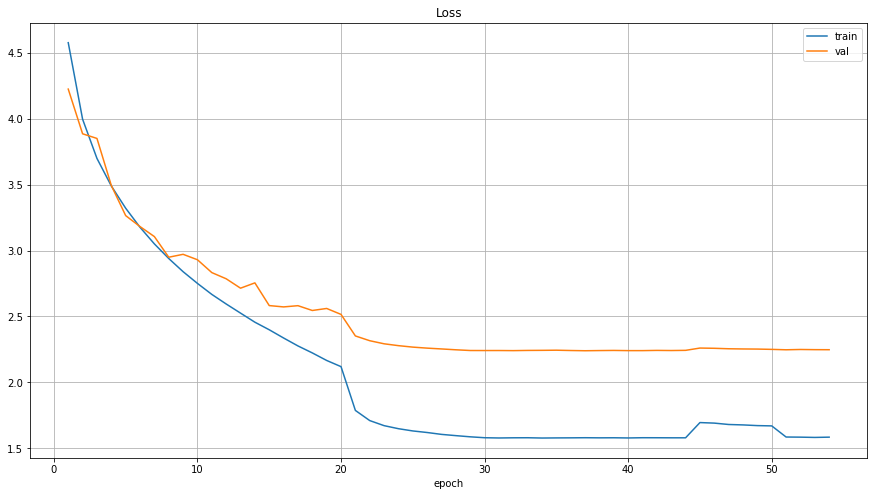

In [52]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(1,1+len(loss_history['train'])), loss_history['train'], label='train')
plt.plot(np.arange(1,1+len(loss_history['val'])), loss_history['val'], label='val')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()
plt.grid()
# plt.ylim(0, 6)
plt.show()

In [53]:
def val_acc(model):
    model.eval()   # Set model to evaluate mode

    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)

    val_acc = running_corrects.double() / dataset_sizes['val']
    
    return val_acc

When everything is done, please compute accuracy on the validation set and report it below.

In [54]:
val_accuracy = val_acc(net) # Your code here
print("Validation accuracy: %.2f%%" % (val_accuracy * 100))

Validation accuracy: 46.60%


# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*

I have analyzing the following paper, and decided to try ResNet for my problem. I started with mini-batch size of 256 as in the paper.
    
    He, Kaiming, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. "Deep residual learning for image recognition." In Proceedings of the IEEE conference on computer vision and pattern recognition, pp. 770-778. 2016.

I mostrly used the following data augmentations because visually the result was close enough to the initial data:
* RandomHorizontalFlip, 
* RandomRotation(30), 
* RandomResizedCrop(64, scale=(.8, 1.)) - min=.8 because sometimes objects are small and near the edge,
* ColorJitter(.3, .3, .3) - parameters seemed to be reasonable visually.

After some experiments with batch_size I did not see signifficant difference between 128, 256 and 512 so I mostly used 256.

Adam optimizer was used with standard params except for lr, as a typical default optimizer choice. Same reason, Cross Entropy Loss and L2 regularization were used.

Learning rate was scheduled (for example, .1 decay every 10 epochs). Sometimes it was changed manually as well. Several experiments showed that it is good to start with lr=0.0001.

Also, training was done in several stages each one having some lr scheduling. The output of each stage was the model with the best validation score (rather then the last one).

I also found that finishing training with unaugmented data gives additional few % to the val loss.

Breif history of experiments:
* VGG11_BN I - 32.50% validation accuracy in 20 epochs.
* Resnet152 - 38.00% validation accuracy in 40 epochs. It overfitted, so I decided to use a model with less parameters.
* Resnet50 - 43.00% val acc in 20 epochs. Training on data with more signifficant augmentations did not improve the result. However, finishing training on data with no augmentations added ~.02 to the accuracy.
* Resnet18 - 43.74% after some semi-manual lr decay steps.
* Same but with batch_size=512 - no improvement.
* Same but with more signifficant data augmentation (180 deg rotation, shear, etc.) - no improvement.
* Resnet34 - 44.79% valication accuracy. Did not use ColorJitter in this one.

Then I noticed that Resnet starts with a Conv layer with kernel size of 7 and stride 2. The images are 64x64, so it seemed reasonable to reduce stride to 1 and use a smaller kernel (5x5). Such modified Resnet18 was used in the next experiment. After training, it had the highest validation accuracy so far - of 46.6%, which is why it was chosen. Because I did not train directly on the validation dataset, I expect to see > 40% accuracy on the test stage with this model.